In [1]:
# Import some modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Set matplotlib style and rendering type
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Define functions to read benchmark results

def read_file(path):
    """Read single CSV file, calculate number of cycles per iteration and number of
       instructions per iteration"""
    data = pd.read_csv(path)
    data['cyc_per_iter'] = data['tot_cyc'] / data['iter']
    data['insn_per_iter'] = data['tot_insn'] / data['iter']
    data.set_index('test', inplace=True)
    return data

# Number of individual runs of each benchmark
NUM_RUNS = 5

def read_files(path):
    """Read data from several runs and concatenate them into single Pandas dataframe"""
    frames = []
    for i in range(0, NUM_RUNS):
        frames.append(read_file('{}_{}.csv'.format(path, i)))
    res = pd.concat(frames)
    return res

In [3]:
# Read benchmark results from current directory
classes = read_files('classes')
hierarchy = read_files('hierarchy')
calls = read_files('calls')
objc = read_files('objc')

In [4]:
def group_and_plot(data, xlabel=None):
    """Group the data collected in several independent runs, calculate
       median and standard deviation"""
    grouped = data.reset_index().groupby('test')['cyc_per_iter'].agg([np.median, np.std])
    f, ax = plt.subplots()
    ax.errorbar(grouped.index, grouped['median'], grouped['std'])
    ax.set_ylim(0, None)
    ax.set_ylabel('cycles')
    if xlabel is not None:
        ax.set_xlabel(xlabel)

## System under test

- CPU: Intel(R) Core(TM) i7-3770K CPU @ 3.50GHz
- RAM: 16 GB
- OS: Linux 3.16.0-4-amd64 #1 SMP Debian 3.16.7-ckt11-1+deb8u4 (2015-09-19) x86_64 GNU/Linux
- glibc: 2.19-18+deb8u1
- gcc version 5.2.0 (GCC)

## Benchmark results

### Benchmark of exception handler search (unrelated classes)

Consider this testcase:

    static volatile int v;

    // Define N=50 empty classes
    namespace {
    class class_0 { };
    // ... 
    class class_49 { };
    } // anon. namespace

    // Define N functions like this:
    void test_throw_0()
    {
        try {
            throw class_0(); // Each function throws an exception of
                             // it's own class, class_0 through class_49
        } catch(class_49&) {
            // The handlers are identical across functions
            v = 49;
        } catch(class_48&) {
            v = 48;
    // ...
        } catch(class_0&) {
            v = 0;
        }
    }   

Now, we measure the number of cycles spent in `test_throw_<i>`, depending on `i`, which determines the index of the catch clause containing the correct handler.

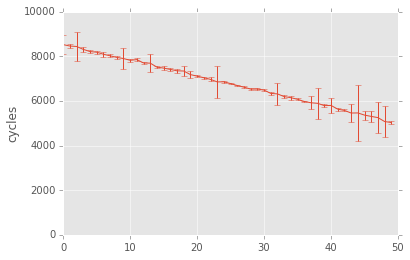

In [5]:
group_and_plot(classes)

### Benchmark of exception handler search (class hierarchy)

Same as above, but classes are organized into hierarchy:

    namespace {
    class class_0 { };
    class class_1 : public class_0 { };
    class class_2 : public class_2 { };
    // ... 
    }

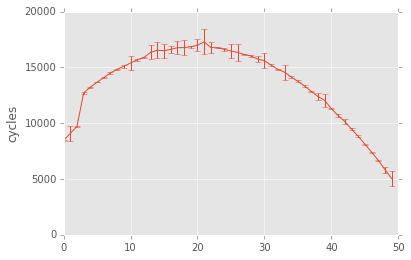

In [6]:
group_and_plot(hierarchy)

### Benchmark of stack unwinding

Consider this testcase:

    static volatile int v;

    __attribute__((noinline)) void call_0()
    {
        throw 1;
    }

    __attribute__((noinline)) void call_1()
    {
        v = 0;
        call_0();
        v = 1;      // Prevent tail call optimization
    }

    // ...

    __attribute__((noinline)) void call_9()
    {
        v = 8;
        call_8();
        v = 9;
    }

    void test_call_0()
    {
        try {
            throw 1; // Exception is handled in the same function
        } catch(int) { }
    }

    void test_call_1()
    {
        try {
            call_0();
        } catch(int) { }
    }
    
    // ...

    void test_call_9()
    {
        try {
            call_9();
        } catch(int) { }
    }
    
We measure the number of cycles spent in `test_call_<i>`.

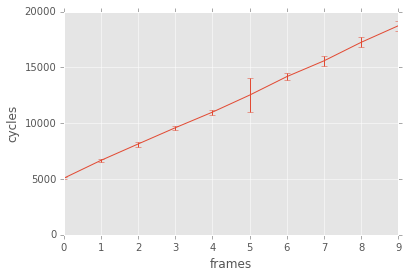

In [7]:
group_and_plot(calls, 'frames')

### Comparison of C++ and Objective C exception handling performance

Testcase for C++ (already mentioned above):

    void test_call_0()
    {
        try {
            throw 1;
        } catch(int) { }
    }
    
Testcase for Objective C:

    void objc_test()
    {
        @try {
            @throw nil;
        } @catch(id ex) { }
    }
    
In reality Objective C will have slightly worse performance because exception object must be allocated separately (G++ stores an exception inside the structure allocated by the language support library, while GNU Objective C stores a pointer in that structure and requires a bit less bookkeeping). Performance drop will depend on the allocator being used, but should be insignificant.

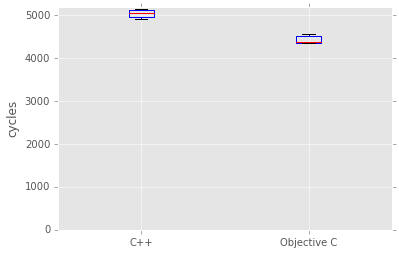

In [8]:
f, ax = plt.subplots()
ax.boxplot([calls.ix[0, 'cyc_per_iter'], objc.ix[0, 'cyc_per_iter']], labels=['C++', 'Objective C'])
ax.set_ylim(0, None)
ax.set_ylabel('cycles')
None

## References
1. [Itanium C++ ABI: Exception Handling](https://mentorembedded.github.io/cxx-abi/abi-eh.html)
2. [System V Application Binary Interface. AMD64 Architecture Processor Supplement](http://www.x86-64.org/documentation/abi.pdf), [v. 0.99.7](http://www.x86-64.org/documentation/abi-0.99.7.pdf)
3. [DWARF Debugging Information Format. Version 4](http://dwarfstd.org/doc/DWARF4.pdf)
4. Posts on exception table formats by Ian Lance Taylor:
 - [.eh_frame](http://www.airs.com/blog/archives/460)
 - [.eh_frame_hdr](http://www.airs.com/blog/archives/462)
 - [.gcc_except_table](http://www.airs.com/blog/archives/464)
6. [Exception Handling in LLVM](http://llvm.org/docs/ExceptionHandling.html)